In [1]:
import tensorflow as tf
import sys
import w2v_utils  as w2v_utils
import numpy as np
import gensim.models
import matplotlib.pyplot as plt
import pandas as pd   
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
from sklearn.preprocessing import scale
import logging
import random
import simplejson as json

setValidation = True   #to create a validation set or not
scaleVectors  = False  #to scale word vectors or not
skipSections  = True   #to skip sections of codes for fast executions

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

# As usual, a bit of setup
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

###Training Data###
training_Input_File       = 'ABSA16_Restaurants_Train_SB1_v2.xml'
training_output_File      = 'ABSA16_Restaurants_Train_SB1_v2.txt'
training_Unique_Sentences = 'ABSA16_Restaurants_Train_SB1_v2_Unique.txt'
w2v_utils.getTraining_setFile("Total Training Sentences with categories:",training_Input_File, training_output_File)
w2v_utils.getSentencesFile(training_Input_File, training_Unique_Sentences)

###Validation Data###
test_Input_File  = 'ABSA15_Restaurants_Test.xml' #test
test_output_File = 'ABSA15_Restaurants_Test.txt'
test_Unique_Sentences = 'ABSA15_Restaurants_Test_Unique.txt'
w2v_utils.getTraining_setFile("Total Validation Sentences with categories:",test_Input_File, test_output_File)
w2v_utils.getSentencesFile(test_Input_File, test_Unique_Sentences)

###Gold Standard Annotations###
#gold_Input_File  = '/home/nouman/Python codes/ABSA_code/Data folder/Datasets/ABSA16_Restaurants_Train_SB1_v2.xml' #train
gold_Input_File  = 'EN_REST_SB1_TEST.xml.gold' #test
gold_output_File = 'EN_REST_SB1_TEST_gold.txt'
gold_Unique_Sentences = 'EN_REST_SB1_TEST_gold_Unique.txt'
w2v_utils.getTraining_setFile("Total Gold Test set Sentences with categories:",gold_Input_File, gold_output_File)
w2v_utils.getSentencesFile(gold_Input_File, gold_Unique_Sentences)

Using TensorFlow backend.


Total Training Sentences with categories: 1708
Total Unique Sentences:  2000
Total Validation Sentences with categories: 582
Total Unique Sentences:  685
Total Gold Test set Sentences with categories: 587
Total Unique Sentences:  676


In [2]:
#model = Word2Vec.load('TRAIN_MODEL')
model = Word2Vec.load('400dm_by_5lac_yelp.model')
#print "Loading GoogleNews-vectors-negative300.bin model" 
#model = Word2Vec.load_word2vec_format('/home/nouman/Python codes/ABSA_code/GoogleNews-vectors-negative300.bin', binary=True) 
#print "Model loaded..."

2017-09-17 11:34:01,320 : INFO : loading Word2Vec object from 400dm_by_5lac_yelp.model
2017-09-17 11:34:01,564 : INFO : loading syn0 from 400dm_by_5lac_yelp.model.syn0.npy with mmap=None
2017-09-17 11:34:01,583 : INFO : loading syn1 from 400dm_by_5lac_yelp.model.syn1.npy with mmap=None
2017-09-17 11:34:01,603 : INFO : setting ignored attribute syn0norm to None
2017-09-17 11:34:01,604 : INFO : setting ignored attribute cum_table to None
2017-09-17 11:34:01,604 : INFO : loaded 400dm_by_5lac_yelp.model


In [3]:
model.most_similar("good")

2017-09-17 11:34:01,632 : INFO : precomputing L2-norms of word weight vectors


[('decent', 0.6036416292190552),
 ('great', 0.5459213256835938),
 ('tasty', 0.5145878195762634),
 ('awesome', 0.43889498710632324),
 ('solid', 0.42857789993286133),
 ('excellent', 0.4117080867290497),
 ('tastey', 0.40314656496047974),
 ('average', 0.39288848638534546),
 ('yummy', 0.38846296072006226),
 ('amazing', 0.384460985660553)]

In [4]:
model.most_similar("bad")

[('terrible', 0.513479471206665),
 ('horrible', 0.4746302366256714),
 ('awful', 0.4508820176124573),
 ('poor', 0.4300382733345032),
 ('soured', 0.399912565946579),
 ('horrific', 0.3849557042121887),
 ('good', 0.38289380073547363),
 ('tainted', 0.3814338147640228),
 ('negative', 0.37759339809417725),
 ('lousy', 0.36431601643562317)]

In [5]:
training_output_File = 'ABSA16_Restaurants_Train_SB1_v2.txt'
test_output_File = 'ABSA15_Restaurants_Test.txt'
gold_output_File = 'EN_REST_SB1_TEST_gold.txt'
finalTrain = 'file'
train = pd.read_csv(training_output_File, header=None, delimiter="\t", quoting=3, names=['review', 'category'])
test  = pd.read_csv(gold_output_File, header=None, delimiter="\t", quoting=3, names=['review', 'category'])
train = w2v_utils.multiHotVectors(train, 'test_labels')
test  = w2v_utils.multiHotVectors(test, 'train_labels')

#filenames = [training_output_File, test_output_File]
#with open(training_output_File, 'w') as outfile:
#    for fname in filenames:
#        with open(fname) as infile:
#            for line in infile:
#                outfile.write(line)

In [6]:
x_train = train["review"]
Y_train = np.array(w2v_utils.multiCategoryVectors(train, classes=12)).astype(int) #train["category"]
x_test  = test["review"]
Y_test  = np.array(w2v_utils.multiCategoryVectors(test, classes=12)).astype(int)  #test["category"]

print train["review"][2],  Y_train[2]
print  test["review"][2],  Y_test[2]


# preparing  data
x_train,Y_train,x_val,Y_val =  w2v_utils.splitDataset(x_train, Y_train, split=0.85) 

####################################### CLEANING REVIEWS ###############################################################
print "Cleaning sentences from training set..."
x_train = w2v_utils.clean(x_train, True)
x_val   = w2v_utils.clean(x_val,True)
x_test  = w2v_utils.clean(x_test,True)
print "Training Set:",len(x_train), "Validation Set:",len(x_val), "Gold Set:",len(x_test)#,"Test Set:",len(x_test) 

#x_train[0],Y_train[0]

Hot encoded vectors shape:  (1708, 12)
Hot encoded vectors shape:  (587, 12)
They never brought us complimentary noodles, ignored repeated requests for sugar, and threw our dishes on the table. [0 0 0 0 0 0 0 0 0 0 0 1]
Not the biggest portions but adequate. [0 0 0 0 0 0 1 0 0 0 0 0]
Cleaning sentences from training set...
Training Set: 1452 Validation Set: 256 Gold Set: 587


In [7]:
######## getting sentence vectors
print "Process of word to vector conversion initiated!"

#Build word vector for training set by using the average value of all word vectors in the tweet, then scale
def buildWordVector(text, size, debug = False):
    sentWords = len(text)  
    #print text, "Sentence Words:",sentWords
    if (sentWords == 0):
        print "Empty Sentence" 
        return np.zeros(size).reshape((1, size))

    count = 0.
    vecSum    = np.zeros(size).reshape((1, size))
    vecMin    = np.zeros(size).reshape((1, size))
    avgvecSum = np.zeros(size).reshape((1, size))
    avgvecMin = np.zeros(size).reshape((1, size))
    NAV_L1    = np.zeros(size).reshape((1, size))
    NAV_L2    = np.zeros(size).reshape((1, size))
    L1_SOM    = np.zeros(size).reshape((1, size))
    L2_SOM    = np.zeros(size).reshape((1, size))
    
    #Loop started!!
    for word in text:
        try:
            wordVector = model[word].reshape((1, size))
            #vecSum = vecSum + wordVector
            if count != 0:
                vecSum =  vecSum+wordVector
                vecMin =  vecMin+wordVector
            else:
                vecSum =  wordVector
                vecMin =  wordVector
                
            count  = count+1.
            
        except KeyError:
            if debug:
                print "not found! ",  word
                count += 1.
            continue
    #Loop ends!!
    
    if count != 0:
        ###### Sum and Subract ######
        vecSum  = vecSum/1
        vecMin  = vecMin/1
        avgvecSum = vecSum #SOW
        avgvecMin = vecMin #DOW
        ##concatenating both sum and subtraction of word vectors
        con_vecSum_vecMin = np.hstack((vecSum,vecMin)) #CONC-Vec
        
        
        ###### Average Sum and Subract ######      
        avgvecSum = avgvecSum/count #Avg-SUM
        avgvecMin = avgvecMin/count #Avg-SUB
        
        ###### Normalized Average Sum and Subract ######        
        NAV_L1 = avgvecSum/np.linalg.norm(avgvecSum,ord=1)    #L1-NAV (Sum)
        NAV_L2 = avgvecSum/np.linalg.norm(avgvecSum, axis=1)  #L2-NAV (Sum)
        
        NAV_L1_Sub = avgvecMin/np.linalg.norm(avgvecMin,ord=1)    #L1-NAV (Sub)
        NAV_L2_Sub = avgvecMin/np.linalg.norm(avgvecMin, axis=1)  #L2-NAV (Sub)
        
        ############ Normalized Word Vectors #############
        ###### L1-SOM ######
        L1_SOM = vecSum/np.linalg.norm(vecSum,ord=1)   #L1-NV (Sum)
        L2_SOM = vecSum/np.linalg.norm(vecSum, axis=1) #L2-NV (Sum)
        
        L1_SOM_Sub = vecMin/np.linalg.norm(vecSum,ord=1)   #L1-NV (Sub)
        L2_SOM_Sub = vecMin/np.linalg.norm(vecSum, axis=1) #L2-NV (Sub)

    return vecSum

######## Converting training, validation and test sentences into vectors
x_train = np.concatenate([buildWordVector(sentence, model.layer1_size, debug = False) for sentence in x_train])
if(scaleVectors):
    x_train = scale(x_train)
print "Training set Sentences word vector dimensions: \n",x_train.shape

if (setValidation):
    x_val = np.concatenate([buildWordVector(sentence, model.layer1_size, debug = False) for sentence in x_val]) 
    if(scaleVectors):
        x_val = scale(x_val)
    print "Validation set Sentences word vector dimensions: \n",x_val.shape
    
x_test = np.concatenate([buildWordVector(sentence, model.layer1_size, debug = False) for sentence in x_test])
if(scaleVectors):
    x_test = scale(x_test)
print "Gold Sentences word vector dimensions: \n",x_test.shape

Process of word to vector conversion initiated!
Empty Sentence
Empty Sentence
Training set Sentences word vector dimensions: 
(1452, 400)
Validation set Sentences word vector dimensions: 
(256, 400)
Gold Sentences word vector dimensions: 
(587, 400)


In [8]:
if skipSections:
    print "TSNE graphical representation of vectors loading..."
    #Plot Word Vectors in 2-dimensional space
    ts = TSNE(2)
    reduced_trained_vectors = ts.fit_transform(x_train)
    print "Training Sentences REDUCED word vector dimensions: \n",reduced_trained_vectors.shape

    if (setValidation):
        reduced_validation_vectors = ts.fit_transform(x_val)
        print "Validation Sentences REDUCED word vector dimensions: \n",reduced_validation_vectors.shape

    reduced_gold_vectors = ts.fit_transform(x_test)
    print "Gold Sentences REDUCED word vector dimensions: \n",reduced_gold_vectors.shape

TSNE graphical representation of vectors loading...
Training Sentences REDUCED word vector dimensions: 
(1452, 2)
Validation Sentences REDUCED word vector dimensions: 
(256, 2)
Gold Sentences REDUCED word vector dimensions: 
(587, 2)


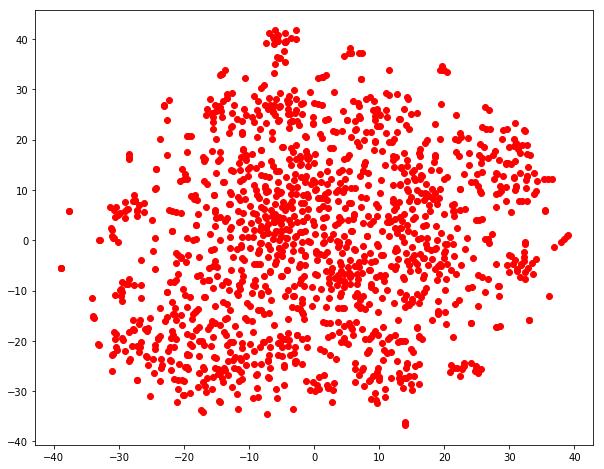

In [9]:
if skipSections:
    #color points by word group to see if Word2Vec can separate them
    for i in range(len(reduced_trained_vectors)):
        if i < len(x_train):
            color = 'r'
        plt.plot(reduced_trained_vectors[i,0], reduced_trained_vectors[i,1], marker='o', color=color, markersize=6)

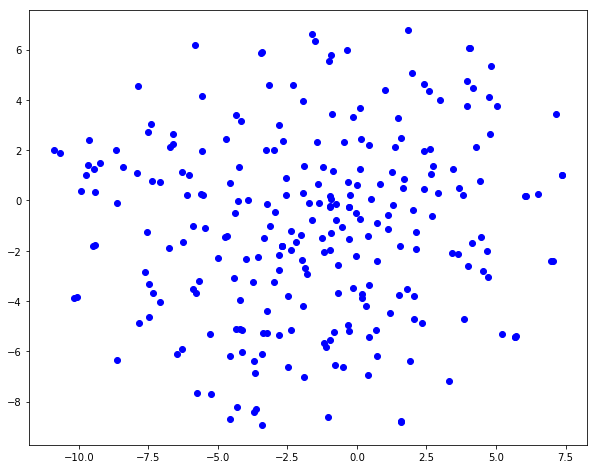

In [10]:
if skipSections:
    if (setValidation):
        #color points by word group to see if Word2Vec can separate them
        for i in range(len(reduced_validation_vectors)):
            if i < len(x_val):
                color = 'b'
            plt.plot(reduced_validation_vectors[i,0], reduced_validation_vectors[i,1], marker='o', color=color, markersize=6)

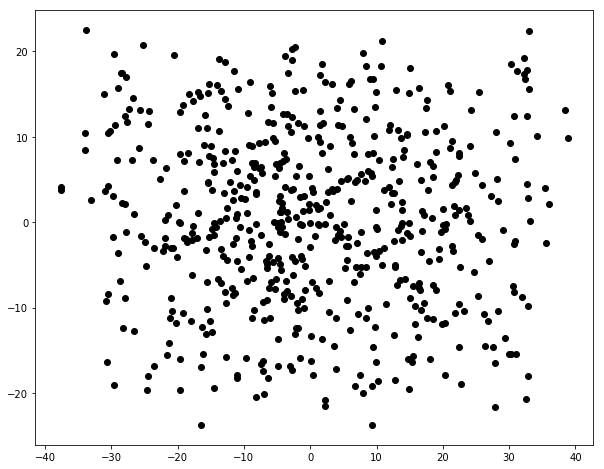

In [11]:
if skipSections:    
    #color points by word group to see if Word2Vec can separate them
    for i in range(len(reduced_gold_vectors)):
        if i < len(x_test):
            color = 'k'
        plt.plot(reduced_trained_vectors[i,0], reduced_gold_vectors[i,1], marker='o', color=color, markersize=6)

In [12]:
#Entities   = np.array(['FOOD', 'SERVICE', 'DRINKS', 'AMBIENCE', 'LOCATION', 'RESTAURANT'])
#Attributes = np.array(['GENERAL', 'QUALITY', 'STYLE_OPTIONS', 'MISCELLANEOUS', 'PRICES'])

############################### Preparing Data with One Hot #######################################
X_train = x_train 
y_train = Y_train
print "Training Data: ",X_train.shape, y_train.shape

###############################Preparing Validation Data
X_val = x_val
y_val = Y_val
print "Validation Data: ",X_val.shape, y_val.shape

###############################Preparing Test Gold Data
X_test = x_test
y_test = Y_test
print "Gold Test Data: ", X_test.shape,y_test.shape

y_train[0], y_val[0], y_test[0]

Training Data:  (1452, 400) (1452, 12)
Validation Data:  (256, 400) (256, 12)
Gold Test Data:  (587, 400) (587, 12)


(array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]))

[226  20  46  30  82 681 128  28 421  97  80 419] [ 57   3  21  12  22 226  48  13 142  33  21 145]
Total number of Training set Categories:  12
Total number of Training set Categories:  11


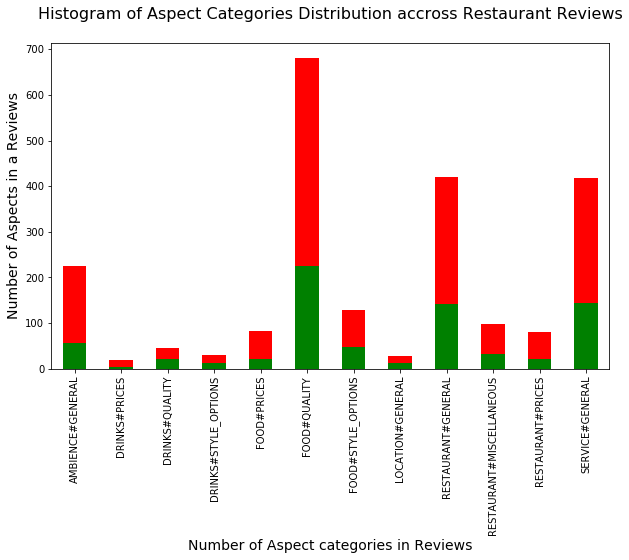

In [13]:
#Frequencies of categories
categories = np.array(['AMBIENCE#GENERAL','DRINKS#PRICES','DRINKS#QUALITY','DRINKS#STYLE_OPTIONS','FOOD#PRICES','FOOD#QUALITY','FOOD#STYLE_OPTIONS','LOCATION#GENERAL','RESTAURANT#GENERAL','RESTAURANT#MISCELLANEOUS','RESTAURANT#PRICES','SERVICE#GENERAL'])
y_tr  = np.nonzero(y_train)[1]
y_tr  = np.bincount(y_tr)

y_va  = np.nonzero(y_val)[1]
y_va  = np.bincount(y_va)

y_te  = np.nonzero(y_test)[1]
y_te  =  np.bincount(y_te)

trainCat = y_tr+y_va
testCat  = y_te
print trainCat, testCat

#Categories in training set
trainFreq = pd.Series(trainCat, index=[trainCat])
print "Total number of Training set Categories: ", trainFreq.value_counts().size
trainFreq = pd.Series(trainFreq.get_values(),  index=categories)
#trainFreq.plot(kind='pie',title='Training Set Categories', figsize=(10, 10))
gra_1 = trainFreq.plot(lw=2, kind='bar', stacked=True, figsize=(10, 8), color='r',fontsize=10)

#Categories in test set
testFreq = pd.Series(testCat, index=[testCat])
print "Total number of Training set Categories: ", testFreq.value_counts().size
testFreq = pd.Series(testFreq.values,  index=categories)
#testFreq.plot(kind='pie', title='Test Set Categories', figsize=(10, 10))
gra_1 = testFreq.plot(lw=2, kind='bar', stacked=True,figsize=(10, 6), color='g', fontsize=10)

gra_1.set_title('Histogram of Aspect Categories Distribution accross Restaurant Reviews\n', fontsize=16)
gra_1.set_ylabel("Number of Aspects in a Reviews", fontsize=14)
gra_1.set_xlabel("Number of Aspect categories in Reviews", fontsize=14)

In [14]:
# Parameters
training_epochs = 100
batch_size = 80
display_step = 5
batch = tf.Variable(0, trainable=False)
regualarization =  0.001

# Network Parameters
n_hidden_1 = 300 # 1st layer num features
n_hidden_2 = 250 # 2nd layer num features

n_input = X_test.shape[1] #model.layer1_size # Vector input (sentence shape: 30*10)
n_classes = 12 # Sentence Category detection total classes (0-11 categories)

#History storing variables for plots
loss_history = []
train_acc_history = []
val_acc_history = []

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])


# Create model
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2'])) 
    return tf.matmul(layer_2, weights['out']) + biases['out']  


# Store layers weight & bias
reset = False #if false then weights will not be initialized randomly 
if  (reset == True):
    w2v_utils.resetModel()#delete old weights
    
weights = {
    'h1':  w2v_utils.weight_variable(n_input, n_hidden_1,    filename="params/weights_h1.txt",  boolean=reset),
    'h2':  w2v_utils.weight_variable(n_hidden_1, n_hidden_2, filename="params/weights_h2.txt",  boolean=reset),
    'out': w2v_utils.weight_variable(n_hidden_2, n_classes,  filename="params/weights_out.txt", boolean=reset) 
}

biases = {
    'b1': w2v_utils.bias_variable([n_hidden_1], filename="params/biases_b1.txt", boolean=reset),
    'b2': w2v_utils.bias_variable([n_hidden_2], filename="params/biases_b2.txt", boolean=reset),
    'out': w2v_utils.bias_variable([n_classes], filename="params/biases_out.txt", boolean=reset)
}
    
# Define loss and optimizer
#learning rate
#Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
learning_rate = tf.train.exponential_decay(
  0.003,           # Base learning rate. #0.002
  batch * batch_size,  # Current index into the dataset.
  X_train.shape[0],    # Decay step.
  0.96,                # Decay rate.
  staircase=True)


# Construct model
pred = tf.nn.sigmoid(multilayer_perceptron(x, weights, biases))

#L2 regularization
l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
    
#Softmax loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))  #labels=..., logits=.

#Total_cost
cost = cost+ (regualarization*0.5*l2_loss)

# Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=batch)

# Initializing the variables
init = tf.initialize_all_variables()

print "Network Initialized!"

Instructions for updating:
Use `tf.global_variables_initializer` instead.


2017-09-17 11:34:57,490 : WARNING : From /home/noman/anaconda2/lib/python2.7/site-packages/tensorflow/python/util/tf_should_use.py:170: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Network Initialized!


In [15]:
from __future__ import division
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

truePred=0
falsePred=0
TP = 0
FN = 0
FP = 0
TN = 0

###http://stackoverflow.com/questions/33759623/tensorflow-how-to-restore-a-previously-saved-model-python
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    predictedlabel = np.zeros(y_test.shape) #test set

    corrPred=0
    # Evaluation of  model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    w2v_utils.do_eval("","","",  sess, correct_prediction, accuracy, pred, X_test, y_test, x, y) #test set
    
    #Test
    #'''
    for i in range(len(X_test)): #X_test
        if (i<=len(y_test)):    
            check,predictedlabel[i], TP_, FP_, TN_, FN_ = w2v_utils.do_eval(test["review"][i],i,"Accuracy of Test set Results: ", sess, correct_prediction, 
                                                             accuracy, pred, X_test[i:i+1], y_test[i:i+1], 
                                                             x, y, True, 0.785, debug=False)
            TP = TP+TP_
            FP = FP+FP_
            TN = TN+TN_
            FN = FN+FN_

            if check == True:
                truePred = truePred+1
            else:
                falsePred = falsePred+1
    #'''

In [16]:
total = np.nonzero(y_test)

#print "\n<------------Correct and inccorrect predictions------------>"
print "TP:",TP,"FP:",FP
print "FN:",FN,"TN:",TN

precision =  TP/(TP+FP)
recall    =  TP/(TP+FN)
F1 = 2*(precision*recall)/(precision+recall)
F1_ = (1 + 1 ** 2) * precision * recall / ((precision * 1 ** 2) + recall) if precision > 0 and recall > 0 else 0.
print "Precision:",precision
print "Recall   :",recall
print "F1 calculated by me!:",F1
print "F1 calculated by AUEB:",F1_
print "F1 micro averaging Library function:",(f1_score(y_test, predictedlabel, average='micro')) #test

y_test =  y_test.astype(int)
predictedlabel = predictedlabel.astype(int)

labels = np.array(['AMBIENCE#GENERAL','DRINKS#PRICES','DRINKS#QUALITY','DRINKS#STYLE_OPTIONS','FOOD#PRICES','FOOD#QUALITY','FOOD#STYLE_OPTIONS','LOCATION#GENERAL','RESTAURANT#GENERAL','RESTAURANT#MISCELLANEOUS','RESTAURANT#PRICES','SERVICE#GENERAL'])
scores = (classification_report(y_test, predictedlabel, target_names=labels)) #test

print "\n-------------------------Classification report:------------------------ \n\n", scores[:870]

TP: 564 FP: 168
FN: 179 TN: 0
Precision: 0.770491803279
Recall   : 0.759084791386
F1 calculated by me!: 0.764745762712
F1 calculated by AUEB: 0.764745762712
F1 micro averaging Library function: 0.764745762712

-------------------------Classification report:------------------------ 

                          precision    recall  f1-score   support

        AMBIENCE#GENERAL       0.75      0.88      0.81        57
           DRINKS#PRICES       0.33      0.67      0.44         3
          DRINKS#QUALITY       0.50      0.33      0.40        21
    DRINKS#STYLE_OPTIONS       0.00      0.00      0.00        12
             FOOD#PRICES       0.60      0.68      0.64        22
            FOOD#QUALITY       0.84      0.90      0.87       226
      FOOD#STYLE_OPTIONS       0.61      0.52      0.56        48
        LOCATION#GENERAL       0.00      0.00      0.00        13
      RESTAURANT#GENERAL       0.77      0.78      0.77       142
RESTAURANT#MISCELLANEOUS       0.50      0.33      0.40

/home/noman/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
